In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from RNN.models import EncoderDecoderGRU
from utils import (
    profile_predict,
    plot_profile,
    behavior_prediction,
    plot_prediction,
    perform_multiple_predictions,
)

In [2]:
curve_dir = {}
curve_dir[1] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/1/1_4_0_0.csv"
)
curve_dir[2] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/2/2_4_0_0.csv"
)
curve_dir[3] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/3/3_4_0_0.csv"
)
curve_dir[4] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/4/4_4_0_0.csv"
)
curve_dir[5] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/5/5_4_0_0.csv"
)
curve_dir[6] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/6/6_4_0_0.csv"
)

pretrained_weights = "/home/mazin/Projects/Thesis/RNN/checkpoints/lemon-pine-110/SEFD-monitor_val-epoch=363-train_loss=0.0001529-val_loss=0.0001356-val_mae=0.01131.ckpt"
pretrained_weights = "/home/mazin/Projects/Thesis/RNN/checkpoints/polar-sky-201/SEFD-monitor_val-epoch=857-train_loss=0.0000321-val_loss=0.0001363-val_mae=0.01209.ckpt"
encoder_input_length = 20
decoder_input_length = 1980
current_min = -2.5
current_max = 1
voltage_min = 2.5
voltage_max = 4.2

In [3]:
model = EncoderDecoderGRU.load_from_checkpoint(pretrained_weights).to("cpu")

### Verify/Test the Model Checkpoint

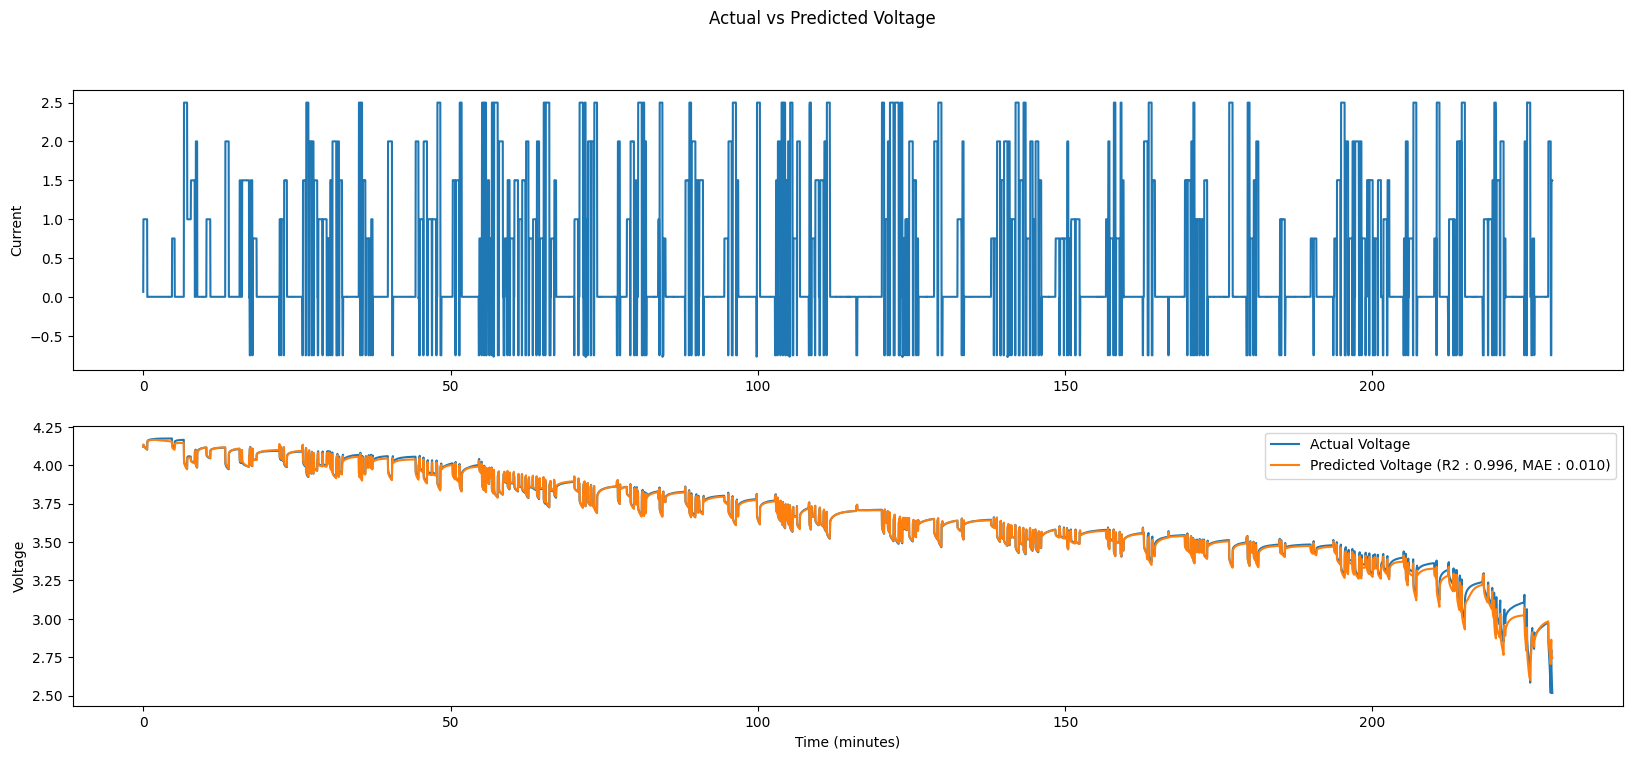

In [4]:
profile = np.random.choice(list(curve_dir.keys()))
actual_current, actual_voltage, predicted_voltage = profile_predict(
    model, curve_dir[profile]
)
plot_profile(actual_current, actual_voltage, predicted_voltage)

### Plot Behavior at Discharging ( Constant Encoder Voltage )

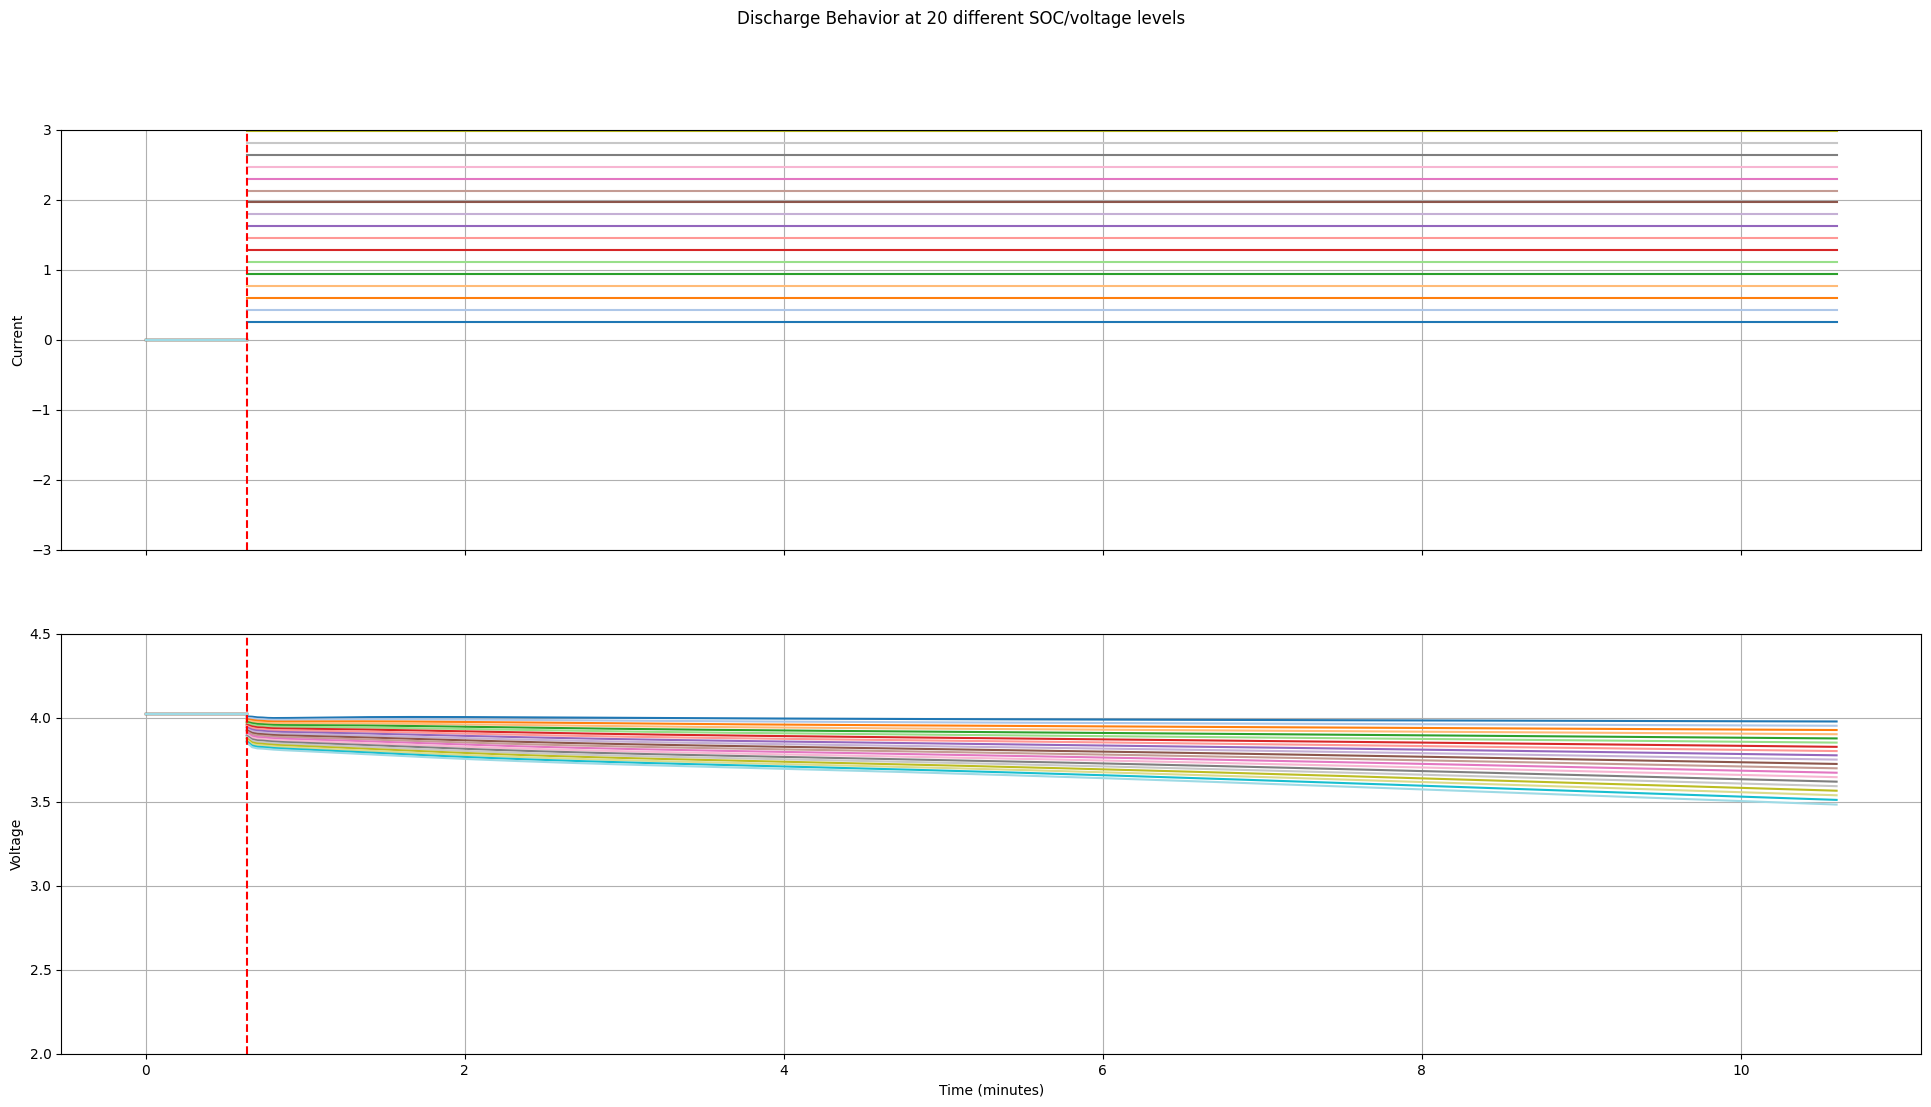

In [5]:
num_predictions = 20
encoder_current_values = [ 0 ] * num_predictions 
encoder_voltage_values = [ 4.02 ] * num_predictions
decoder_current_values = np.linspace(
 0.25, 3.5, num_predictions
)
encoder_current, decoder_current, encoder_voltage, predicted_voltage = (
    perform_multiple_predictions(
        model,
        encoder_current_values,
        encoder_voltage_values,
        decoder_current_values,

        decoder_input_length=300,
    )
)

plot_prediction(
    encoder_current,
    decoder_current,
    encoder_voltage,
    predicted_voltage,
    title=f"Discharge Behavior at {num_predictions} different SOC/voltage levels",
)

#### Quantify the Pure Ohmic Drop Error ( Fixed Voltage / SOC Level)

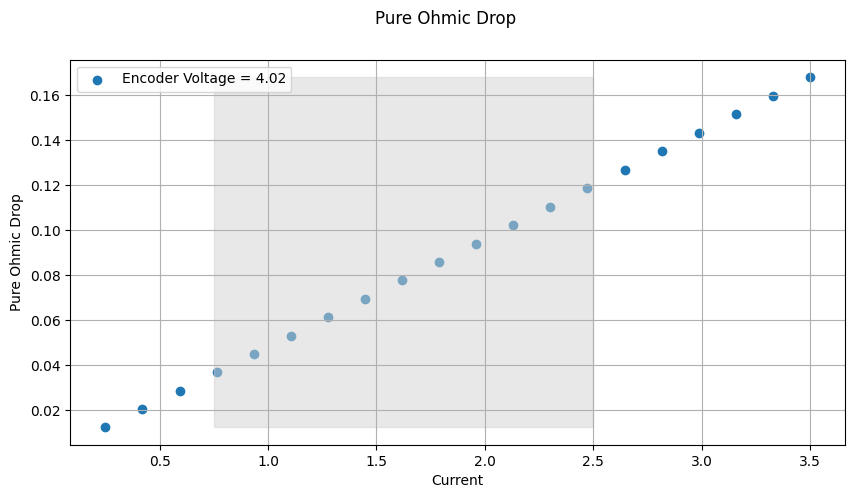

In [6]:
"""
Compute dV/dI by keeping the encoder voltage fixed and varying the current
Goal : It should be constant. 
Method : Compute the std of the whole set of values
"""
_decoder_voltage = np.array([element[0] for element in predicted_voltage])

fig, ax = plt.subplots(1, figsize=(10,5))
iR_drop = (encoder_voltage_values - _decoder_voltage)
ax.scatter(decoder_current_values, iR_drop, label = f"Encoder Voltage = {encoder_voltage_values[0]:.2f}")
ax.fill_betweenx(
    iR_drop, 2.5, 0.75, color="lightgray", alpha=0.5
)
fig.suptitle("Pure Ohmic Drop")
ax.set_xlabel("Current")
ax.set_ylabel("Pure Ohmic Drop")
ax.legend()
ax.grid("True")

In [ ]:
"""
Compute the slope of the discharge curve by keeping the encoder voltage fixed and varying the current
Expectation : It should increase (abs) as the current increases.
Reality : 
"""

start = int(predicted_voltage[0].shape[0] / 3)

slopes = []
for i in range(num_predictions):
    slopes.append(np.polyfit(np.arange(start), predicted_voltage[i][-start:], 1)[0])
fig, ax = plt.subplots(1, figsize=(10,5))
ax.scatter(decoder_current_values, slopes, label = f"Encoder Voltage = {encoder_voltage_values[0]:.2f}")


ax.fill_betweenx(
    slopes, 2.5, 0.75, color="lightgray", alpha=0.5
)
fig.suptitle("Change in discharge rate")
ax.set_xlabel("Current")
ax.set_ylabel("Slope")
ax.legend()
ax.grid("True")